# Predict stock price using Time Series analysis with SARIMA model

Importing and installing libraries

In [129]:
!pip install -U statsmodels

In [130]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
plt.style.use(style="seaborn")

In [131]:
##Importing Packages
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from scipy import stats 
from statsmodels.graphics.gofplots import qqplot as qq
from scipy.stats import kurtosis
import scipy
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.core.window.rolling import Rolling
from sklearn.model_selection import train_test_split as split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import warnings
import itertools
warnings.filterwarnings("ignore")
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit
from IPython import display
from matplotlib import pyplot
import os
import re
from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
import warnings
from matplotlib.patches import Patch

## Loading Data

From Yahoo Finance using yfinance package

In [132]:
!pip install yfinance
import yfinance as yf

In [133]:
data = yf.download("AAPL", start="2012-01-01", end="2019-12-31")

[*********************100%***********************]  1 of 1 completed


In [134]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.519278,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.586555,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.726294,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.859331,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.838936,394024400


In [135]:
##Summary
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2.011000e+03
mean,31.676867,31.956899,31.395064,31.685309,29.471148,2.379867e+08
std,12.620938,12.731575,12.531235,12.644592,12.931796,1.873543e+08
min,13.856071,14.271429,13.753571,13.947500,12.064586,4.544800e+07
25%,21.470714,21.679464,21.264108,21.550535,18.509647,1.103426e+08
50%,28.262501,28.547501,27.967501,28.262501,25.948921,1.738760e+08
75%,41.297501,41.852499,40.856249,41.311251,39.469067,2.988412e+08
max,72.779999,73.492500,72.029999,72.879997,71.398903,1.506120e+09


In [136]:
##Exploring Data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2011 entries, 2012-01-03 to 2019-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2011 non-null   float64
 1   High       2011 non-null   float64
 2   Low        2011 non-null   float64
 3   Close      2011 non-null   float64
 4   Adj Close  2011 non-null   float64
 5   Volume     2011 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 110.0 KB


## Data Preprocessing

Converting Date to DateTime Object

In [137]:
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data.set_index('Date', inplace=True)

In [138]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.519278,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.586555,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.726294,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.859331,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.838936,394024400


In [139]:
##Checking Null Values
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Visualizing

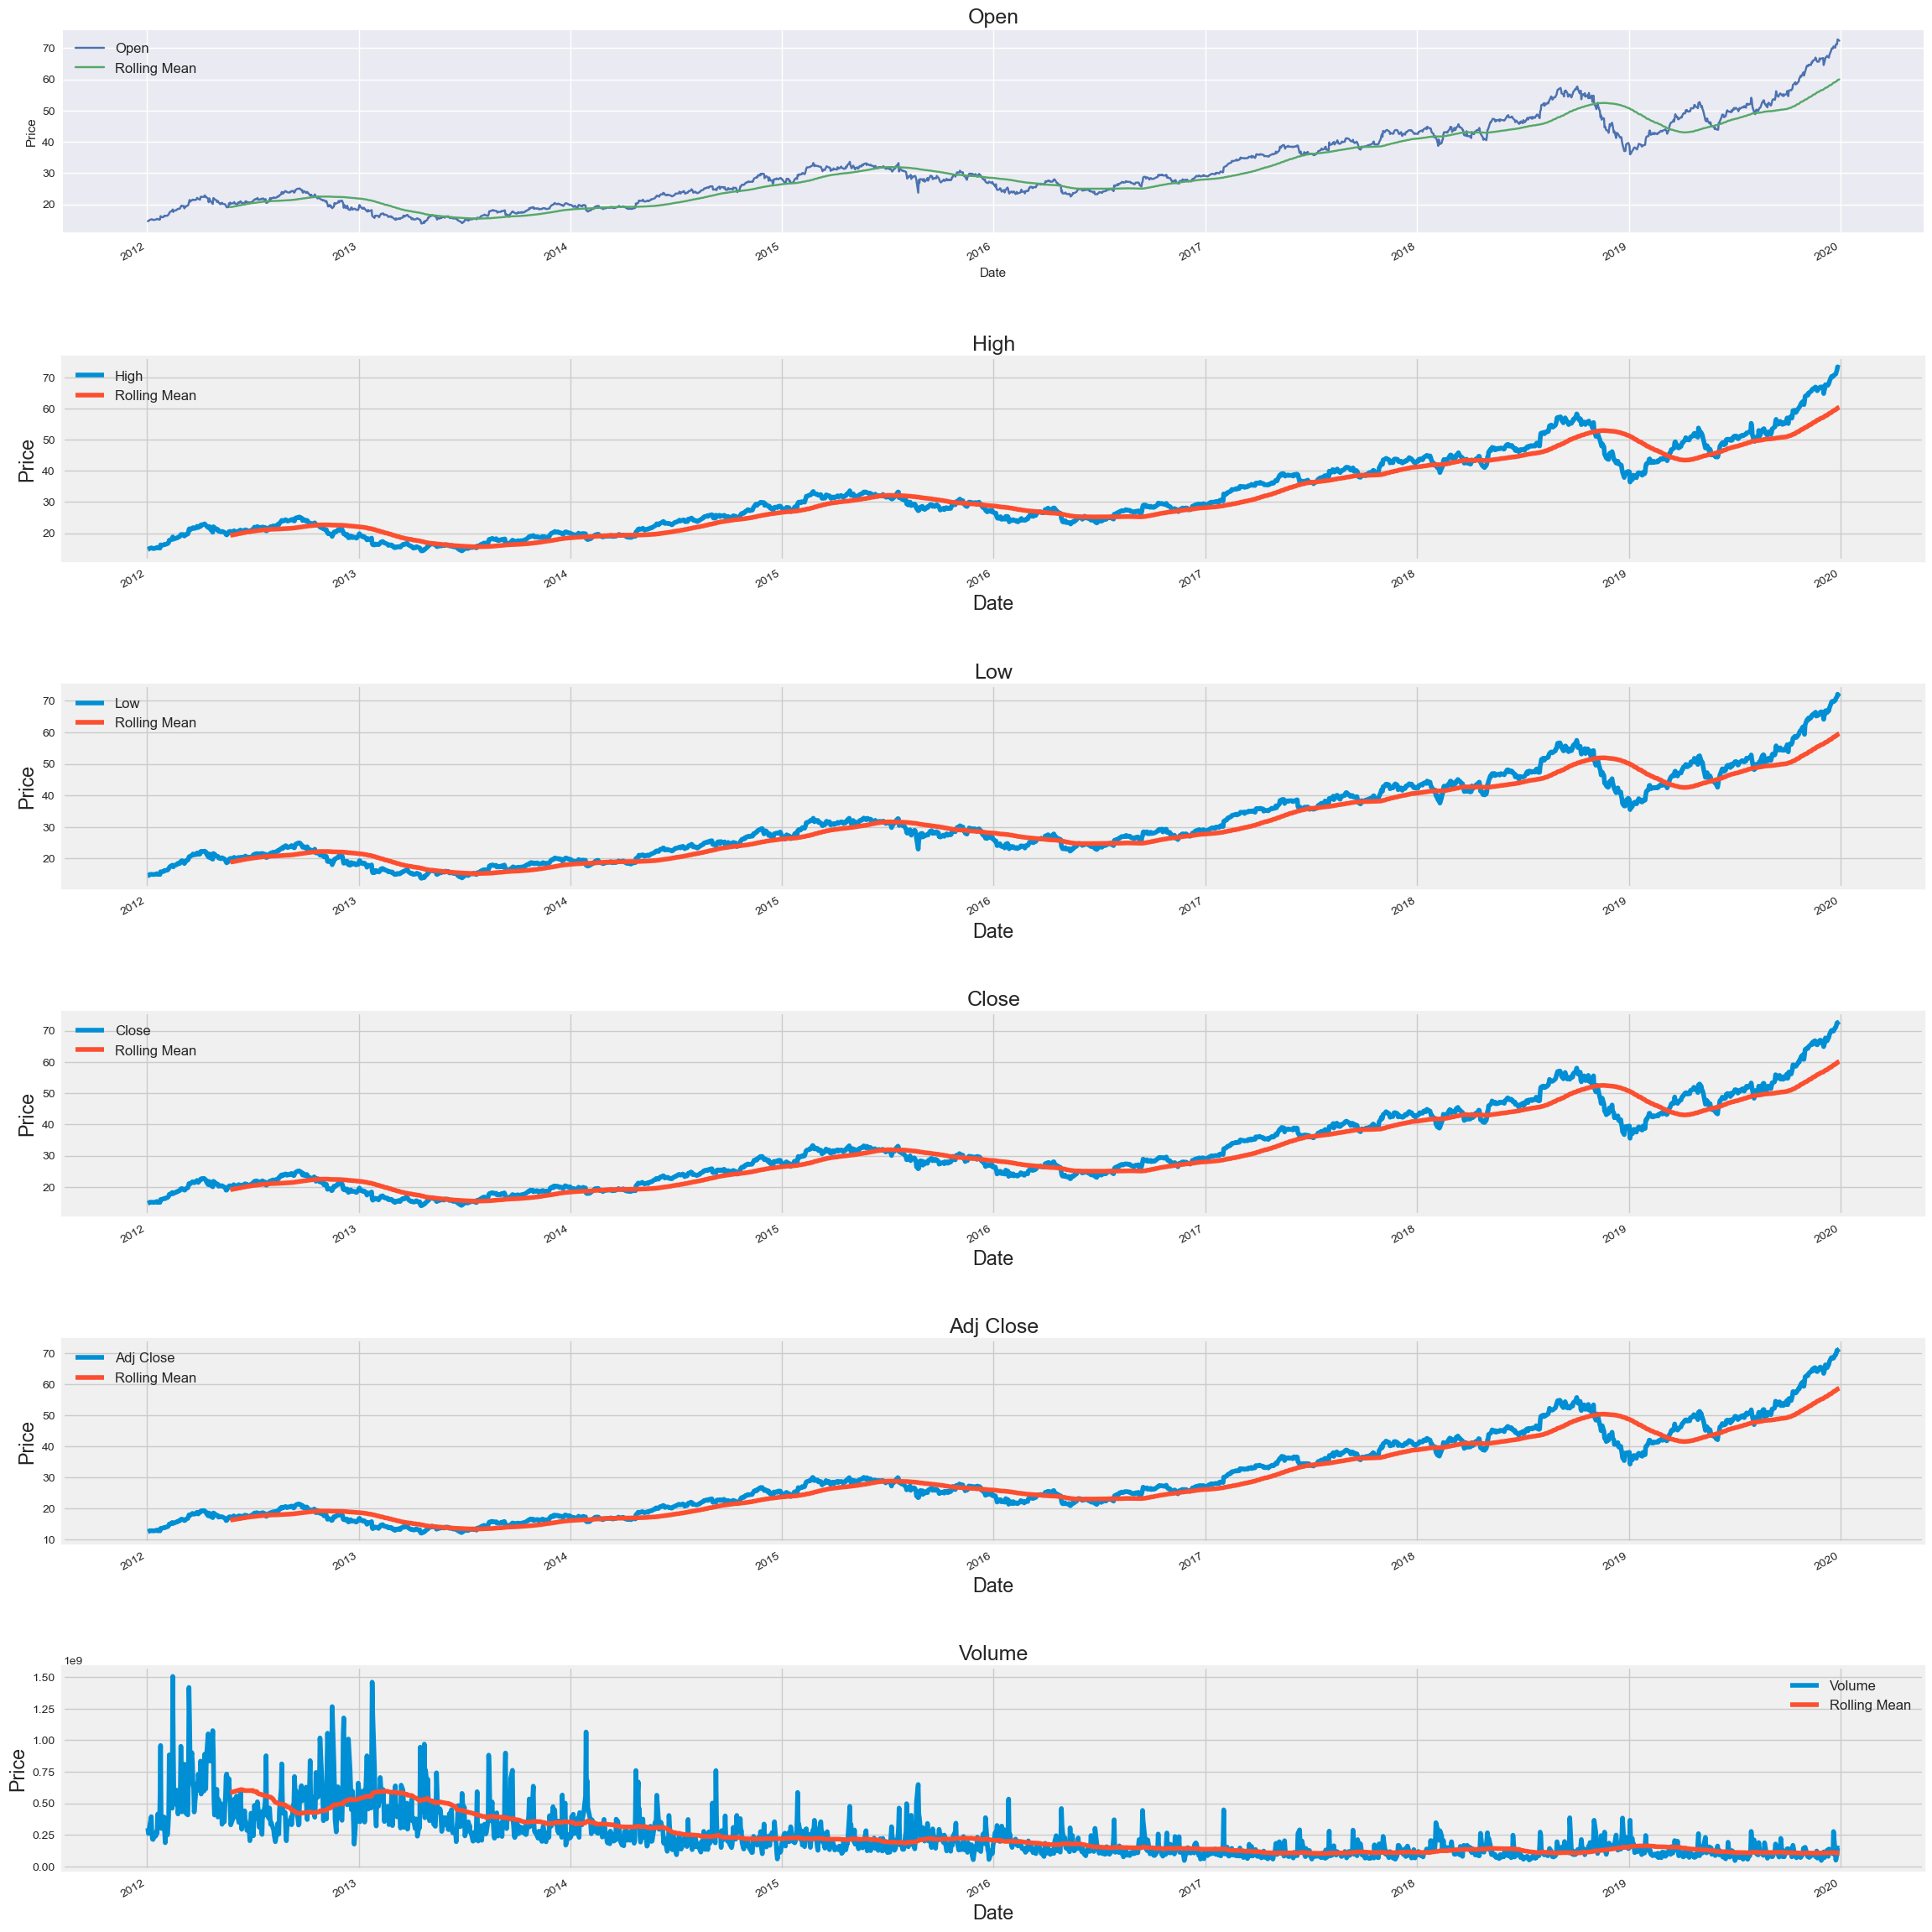

In [140]:
col_names = data.columns

fig = plt.figure(figsize=(24, 24))
for i in range(6):
  ax = fig.add_subplot(6,1,i+1)
  ax.plot(data.iloc[:,i],label=col_names[i])
  data.iloc[:,i].rolling(100).mean().plot(label='Rolling Mean')
  ax.set_title(col_names[i],fontsize=18)
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  ax.patch.set_edgecolor('black')  
  plt.style.context('fivethirtyeight')
  plt.legend(prop={'size': 12})
  plt.style.use('fivethirtyeight')

fig.tight_layout(pad=3.0)

plt.show()

## Choosing target variable

In this analysis we will use Adj Close as our target variables we can eliminate features like Open,Low, High Close automatically.

In [141]:
data_feature_selected = data.drop(axis=1,labels=['Open','High','Low','Adj Close','Volume'])

In [142]:
col_order = ['Close']
data_feature_selected = data_feature_selected.reindex(columns=col_order)
data_feature_selected

,Close
Date,
2012-01-03,14.686786
2012-01-04,14.765714
2012-01-05,14.929643
2012-01-06,15.085714
2012-01-09,15.061786
...,...
2019-12-23,71.000000
2019-12-24,71.067497
2019-12-26,72.477501


## Resampling

In [143]:
##Resample Data to Monthly instead of Daily by Aggregating Using Mean
monthly_mean = data_feature_selected['Close'].resample('M').mean()

In [144]:
monthly_data = monthly_mean.to_frame()
monthly_data

,Close
Date,
2012-01-31,15.306357
2012-02-29,17.770393
2012-03-31,20.625276
2012-04-30,21.642964
2012-05-31,20.166899
...,...
2019-08-31,51.239432
2019-09-30,54.498750
2019-10-31,58.821630


## Exploratory Data Analysis

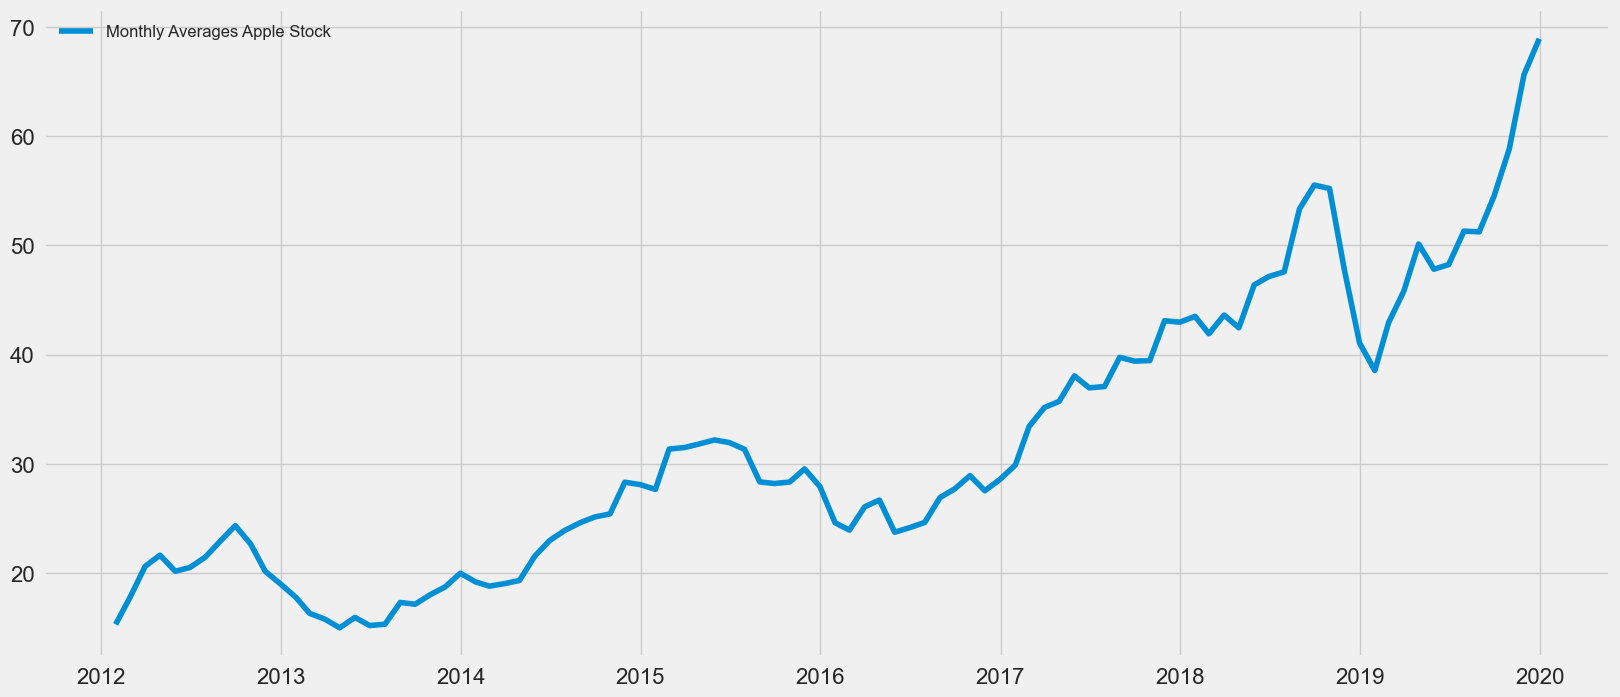

In [145]:
##Monthly Stock Price 
fig = plt.figure(figsize=(18,8))
plt.plot(monthly_data['Close'],label='Monthly Averages Apple Stock')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_title('Monthly Resampled Data')
plt.style.use('fivethirtyeight')
plt.legend(prop={'size': 12})
plt.show()

In [146]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.strftime('%B')
monthly_data['dayofweek'] = monthly_data.index.strftime('%A')
monthly_data['quarter'] = monthly_data.index.quarter
monthly_data

,Close,Year,Month,dayofweek,quarter
Date,,,,,
2012-01-31,15.306357,2012,January,Tuesday,1
2012-02-29,17.770393,2012,February,Wednesday,1
2012-03-31,20.625276,2012,March,Saturday,1
2012-04-30,21.642964,2012,April,Monday,2
2012-05-31,20.166899,2012,May,Thursday,2
...,...,...,...,...,...
2019-08-31,51.239432,2019,August,Saturday,3
2019-09-30,54.498750,2019,September,Monday,3
2019-10-31,58.821630,2019,October,Thursday,4


(array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

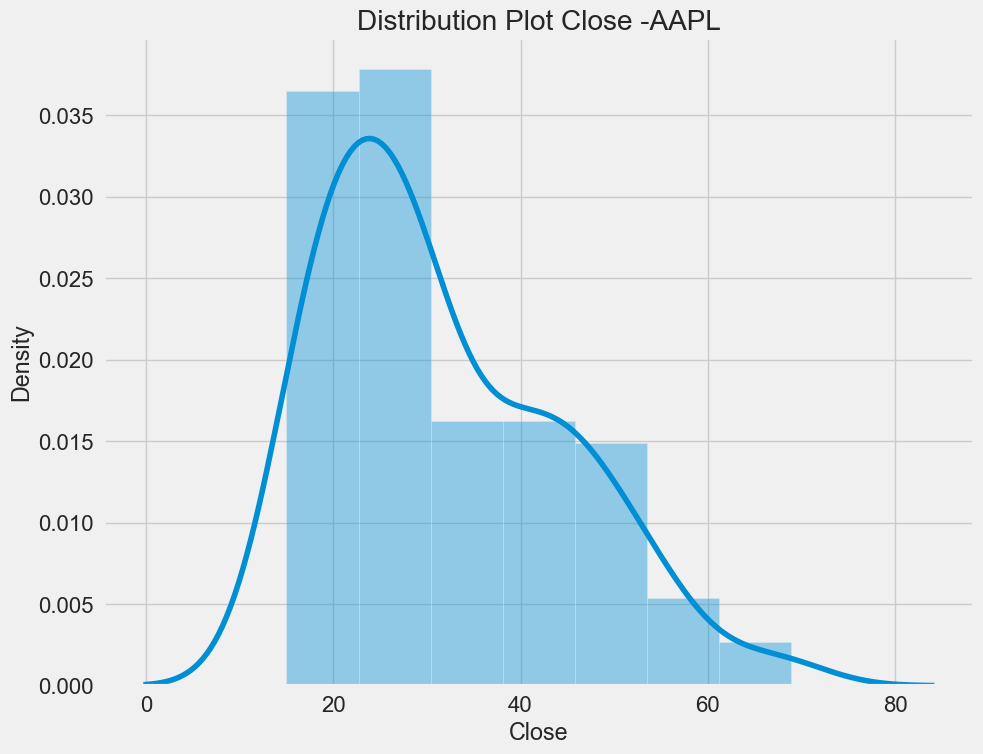

In [147]:
##Checking Distribution of Our Data 
import seaborn as sns
fig = plt.figure(figsize=(10,8))
sns.distplot(monthly_data['Close']).set_title("Distribution Plot Close -AAPL")
ax.tick_params(labelsize=12)
sns.set(font_scale=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

Distribution shows Right Skew

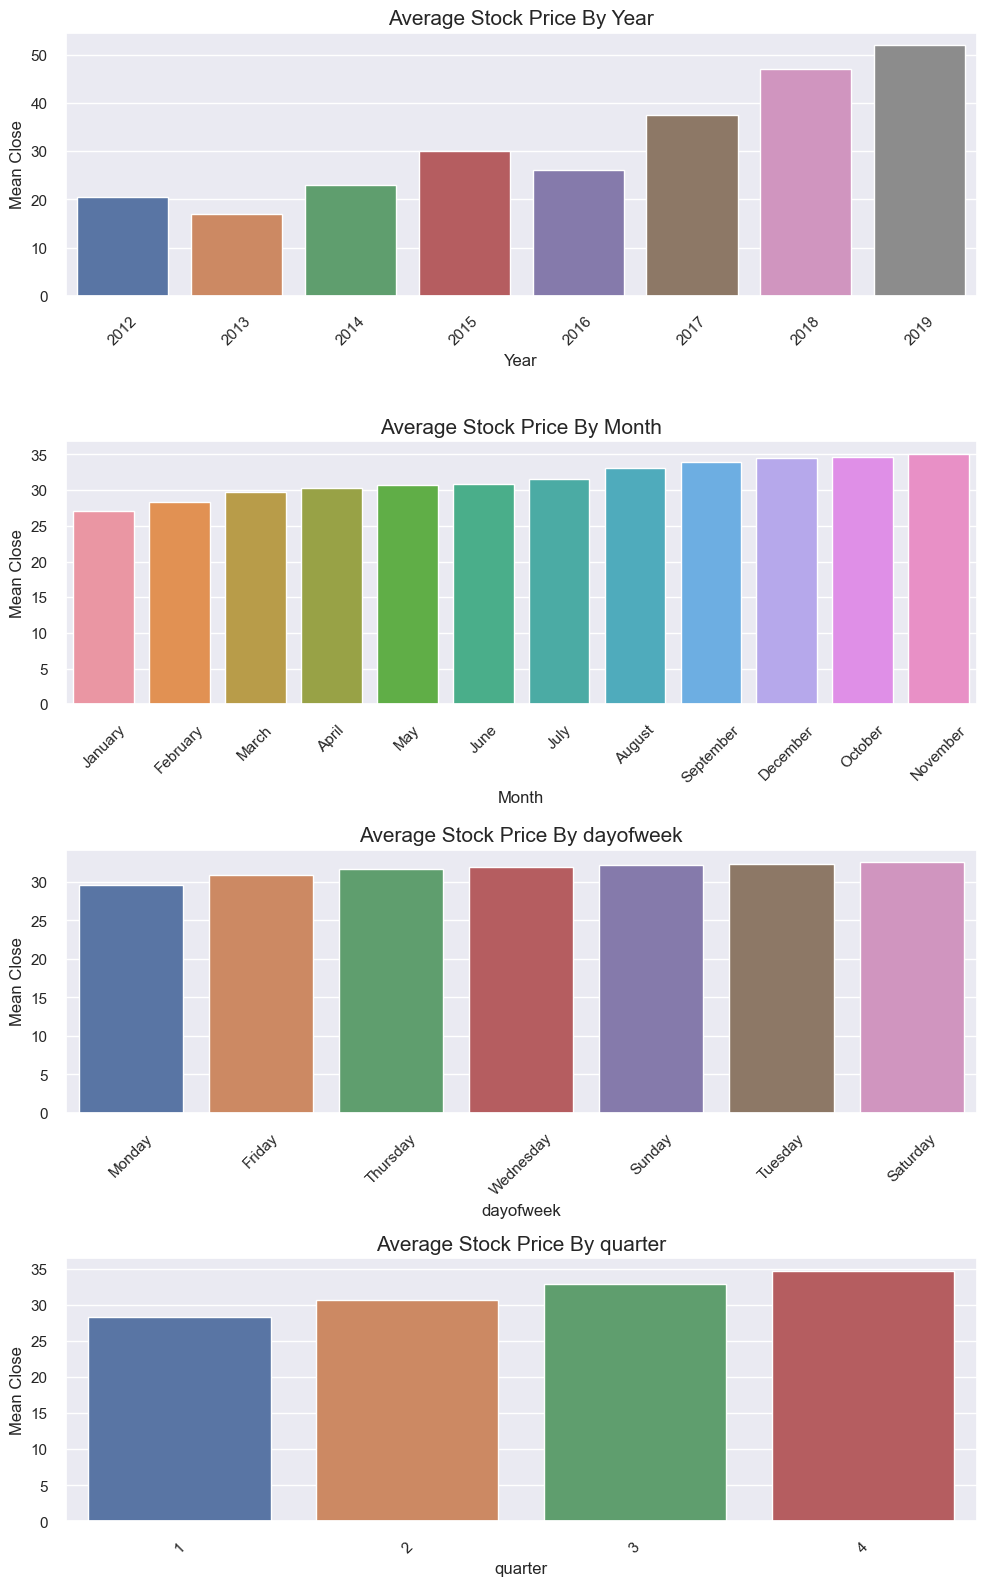

In [148]:
fig = plt.figure(figsize=(10,16))
fig.set_size_inches(10,16)
group_cols = monthly_data.columns

for enum,i in enumerate(group_cols[1:]):
  ax = fig.add_subplot(4,1,enum+1)
  Aggregated = pd.DataFrame(monthly_data.groupby(str(i))["Close"].mean()).reset_index().sort_values('Close')
  sns.barplot(data=Aggregated,x=str(i),y="Close",ax=ax)
  ax.set(xlabel=str(i), ylabel='Mean Close')
  ax.set_title("Average Stock Price By {}".format(str(i)),fontsize=15)
  plt.xticks(rotation=45)
  
plt.tight_layout(pad=1)

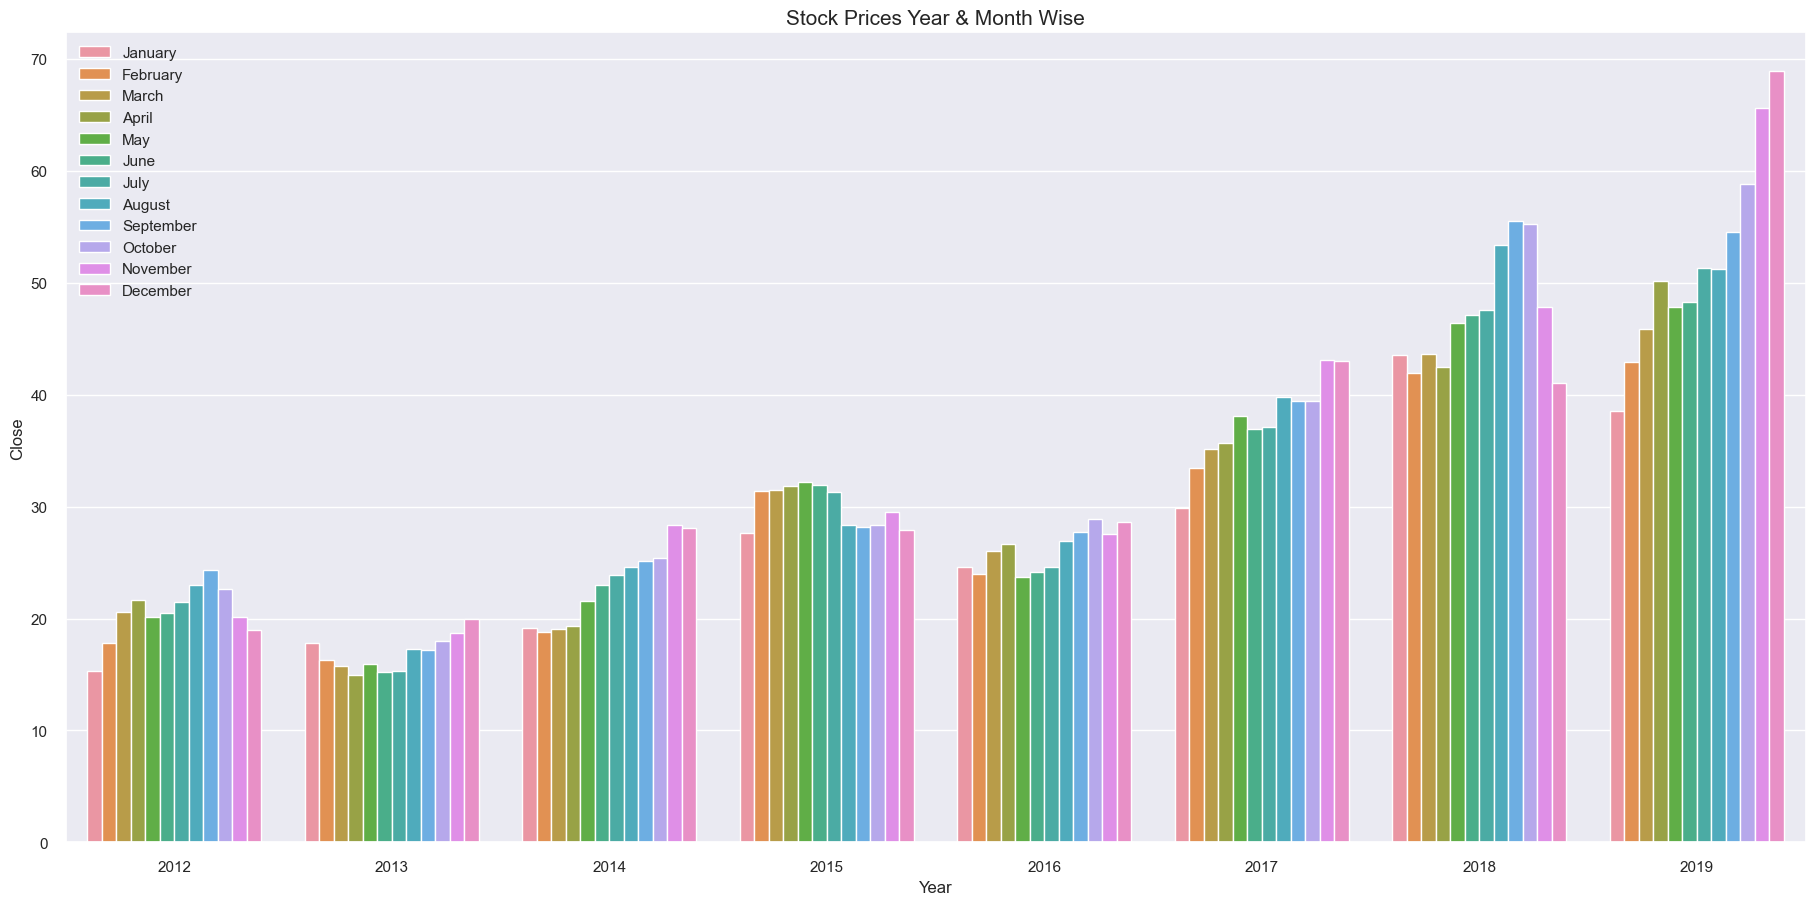

In [149]:
fig, ax = plt.subplots(figsize=(20,10))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="Close",hue = 'Month',data=monthly_data)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(loc='upper left')
plt.show()

Above figure shows that the Period from July-September seems to push stock price above in comparision to other months. The primary reason for this is as Apple has a product cycle release date during this time.

## Decomposition of Time Series

<Figure size 2000x1600 with 0 Axes>

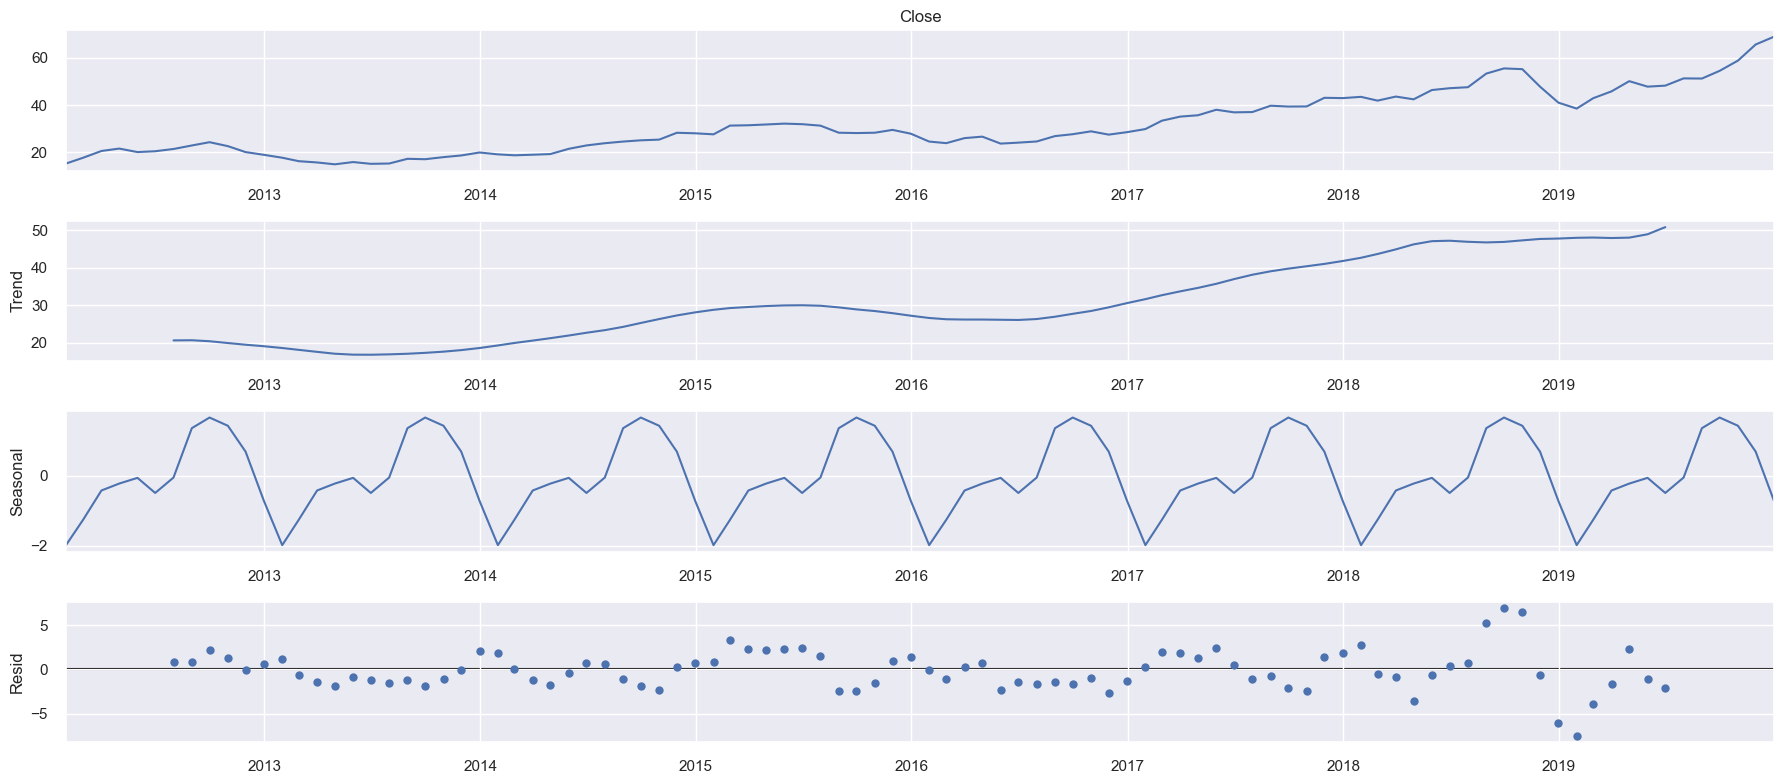

In [150]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
plt.figure(figsize=(20,16))
decomposed_series = sd(monthly_data['Close'],model='additive', period=12)
decomposed_series.plot()
plt.show()

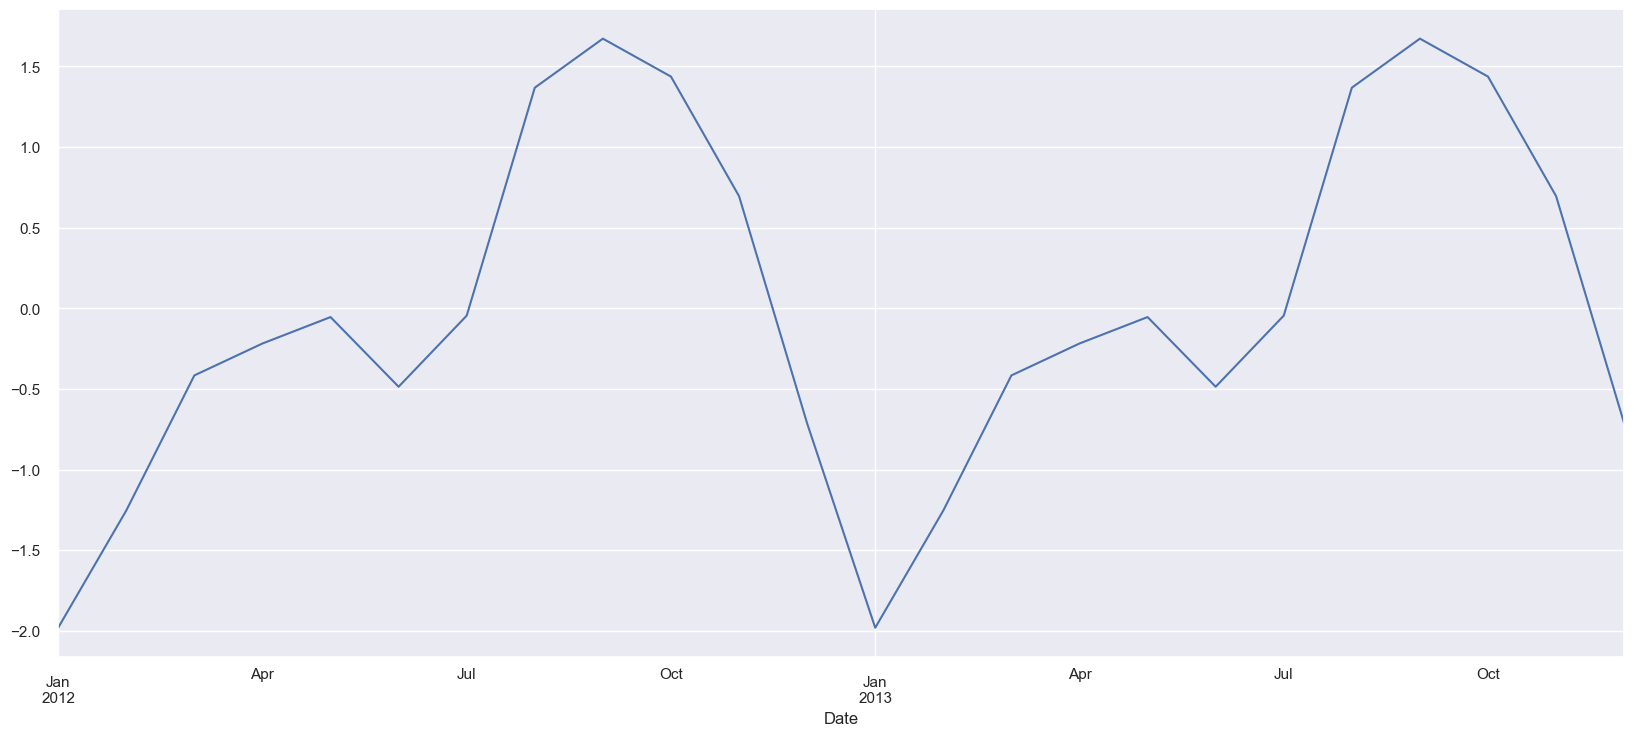

<Figure size 800x800 with 0 Axes>

In [151]:
#Observing Seasonality
decomposed_series.seasonal['2012':'2013'].plot()
fig = plt.figure(figsize=(8,8))

Trend : Overall an Upward Trend

Seasonality: There appears to be a 12-month seasonal pattern is visible, AAPL has rallied during the Holiday season as expected. Since Holiday period has good sales for Apple Over the Years.

## Stationary Test

Using Augmented Dickey-Fuller(ADF) Test

Null Hypothesis: Time series has a unit root -It is non-stationary

Alternate Hypothesis: Time series does not have a unit root -It is stationary

Time Series is Stationary if we have constant mean,constant variance and No Trend and Seasonality.

In [152]:
#ADF Test

def ad_fuller_func(X):
  result_ad_fuller = adfuller(X)
  print('ADF Statistic: %f' % result_ad_fuller[0])
  print('p-value: %f' %result_ad_fuller[1])
  print('Critical Values:')
  for key, value in result_ad_fuller[4].items():
	  print('\t%s: %.3f' % (key, value))
 
  if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
    print('Reject Null Hypothesis-Time Series is Stationary')
  else:
    print('Failed to Reject Null Hypothesis-Time Series is Non-Stationary')

In [153]:
ad_fuller_func(monthly_data['Close'])

ADF Statistic: 0.512110
p-value: 0.985237
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583
Failed to Reject Null Hypothesis-Time Series is Non-Stationary


## Transformations To Make Series Stationary

In [154]:
##Differencing By 1
monthly_diff = monthly_data['Close'] - monthly_data['Close'].shift(1)

In [155]:
monthly_diff

Date
2012-01-31         NaN
2012-02-29    2.464036
2012-03-31    2.854883
2012-04-30    1.017688
2012-05-31   -1.476065
                ...   
2019-08-31   -0.064659
2019-09-30    3.259318
2019-10-31    4.322880
2019-11-30    6.808496
2019-12-31    3.287248
Freq: M, Name: Close, Length: 96, dtype: float64

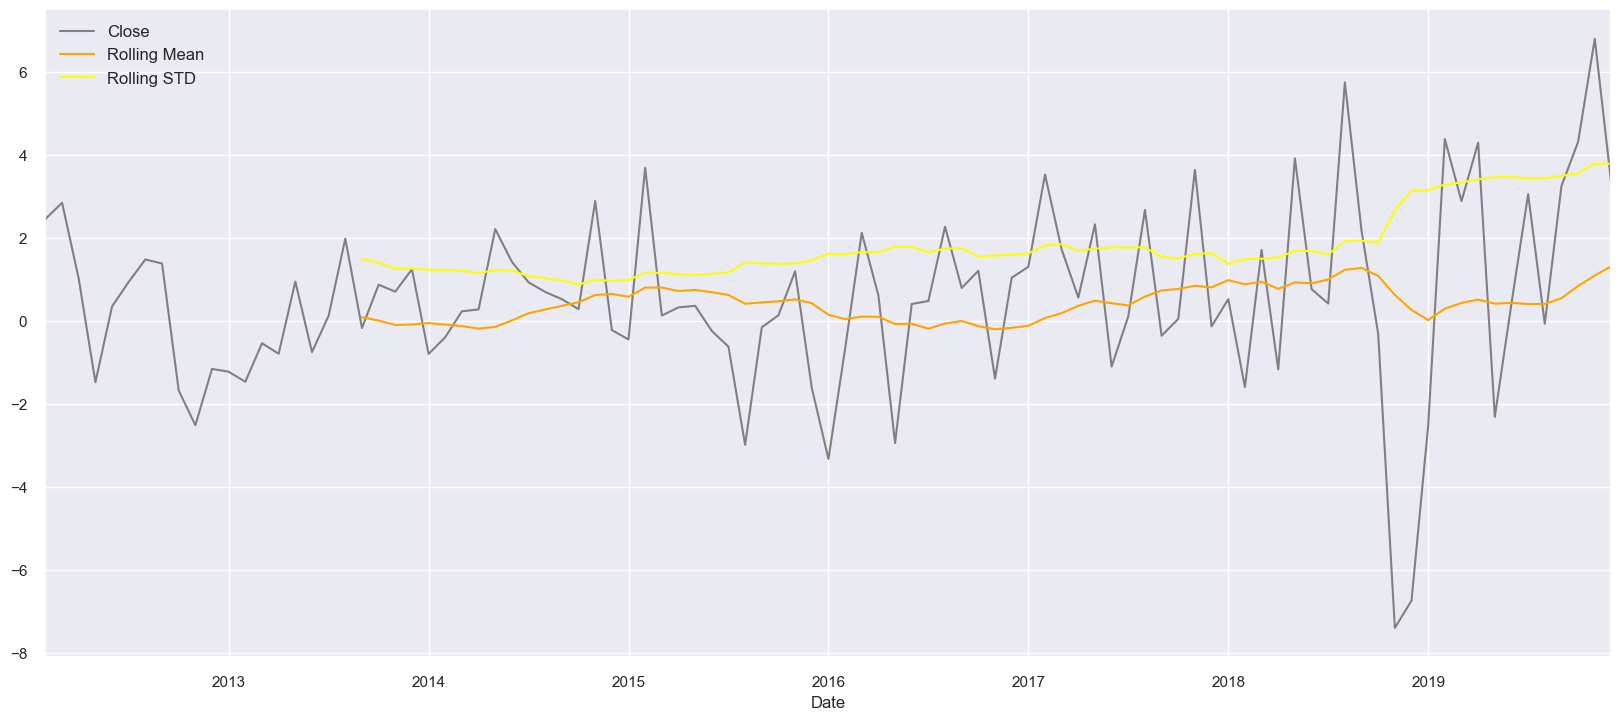

In [156]:
monthly_diff[1:].plot(c='grey')
monthly_diff[1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
monthly_diff[1:].rolling(20).std().plot(label='Rolling STD',c='yellow')
plt.legend(prop={'size': 12})

In [157]:
##Checking if Time Series is Stationary by Running ADF Test
ad_fuller_func(monthly_diff[1:])

ADF Statistic: -6.555009
p-value: 0.000000
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583
Reject Null Hypothesis-Time Series is Stationary


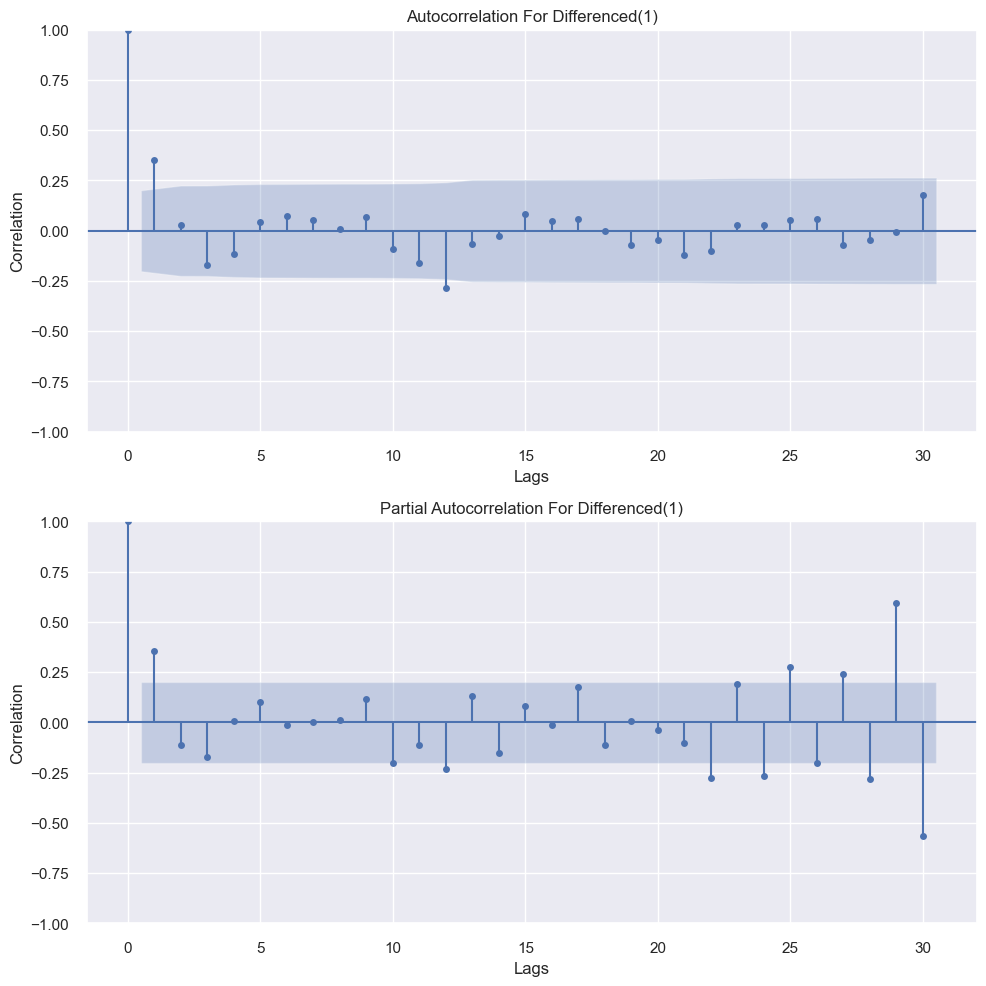

In [182]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,10))
acf = plot_acf(monthly_diff[1:],lags=30,ax=ax1)
pacf = plot_pacf(monthly_diff[1:],lags=30,ax=ax2)
ax1.set_title('Autocorrelation For Differenced(1)')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_title('Partial Autocorrelation For Differenced(1)')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

According to the ACF and PACF we can confirm that Differencing once has transformed series into Stationary
Here, p=1, q=1

### Modelling Seasonal ARIMA

In [174]:
modelling_series = monthly_data['Close']
modelling_series

Date
2012-01-31    15.306357
2012-02-29    17.770393
2012-03-31    20.625276
2012-04-30    21.642964
2012-05-31    20.166899
                ...    
2019-08-31    51.239432
2019-09-30    54.498750
2019-10-31    58.821630
2019-11-30    65.630126
2019-12-31    68.917374
Freq: M, Name: Close, Length: 96, dtype: float64

### Train-Test Split

In [250]:
from sklearn.model_selection import train_test_split as split
train,test = split(modelling_series,train_size=0.6,shuffle=False)

In [251]:
train.head(2)

Date
2012-01-31    15.306357
2012-02-29    17.770393
Freq: M, Name: Close, dtype: float64

In [252]:
test.head(2)

Date
2016-10-31    28.926786
2016-11-30    27.538571
Freq: M, Name: Close, dtype: float64

In [253]:
print('Train',len(train))
print('Test',len(test))

Train 57
Test 39


In [254]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of grid search Model parameter combinations for Seasonal-ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

Examples of grid search Model parameter combinations for Seasonal-ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)


In [255]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of grid search Model parameter combinations for Seasonal-ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

Examples of grid search Model parameter combinations for Seasonal-ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)


Carrying out Grid Search to Select Parameters especially for Seasonal Component of the Time Series .
Parameters for Series already indicate Non-Seasonality Part with Order (1,1,1).

AR(1) derived by the PACF plot

MA(1) derived by the ACF Plot

Differencing(1) derived by differencing and observing stationarity.

In [221]:
#Using Auto-Arima for p, d, q
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
stepwise_fit = auto_arima(train, trace=True,
           suppress_warnings=True)
stepwise_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=205.619, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=203.473, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=202.135, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=204.887, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=203.680, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=200.967, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=202.603, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=202.329, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.489 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -98.484
Date:                Wed, 30 Nov 2022   AIC                            200.967
Time:                        10:47:18   BIC                            205.018
Sample:                    01-31-2012   HQIC                           202.538
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3603      0.156      2.308      0.021       0.054       0.666
sigma2         1.9678      0.412      4.781      0.000       1.161       2.775
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.03
Prob(Q):                              0.77   Prob(JB):                         0.99
Heteroskedasticity (H):               1.33   Skew:                            -0.05
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=222.617, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=220.201, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=208.468, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=220.633, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=206.543, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=218.222, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.399 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. O

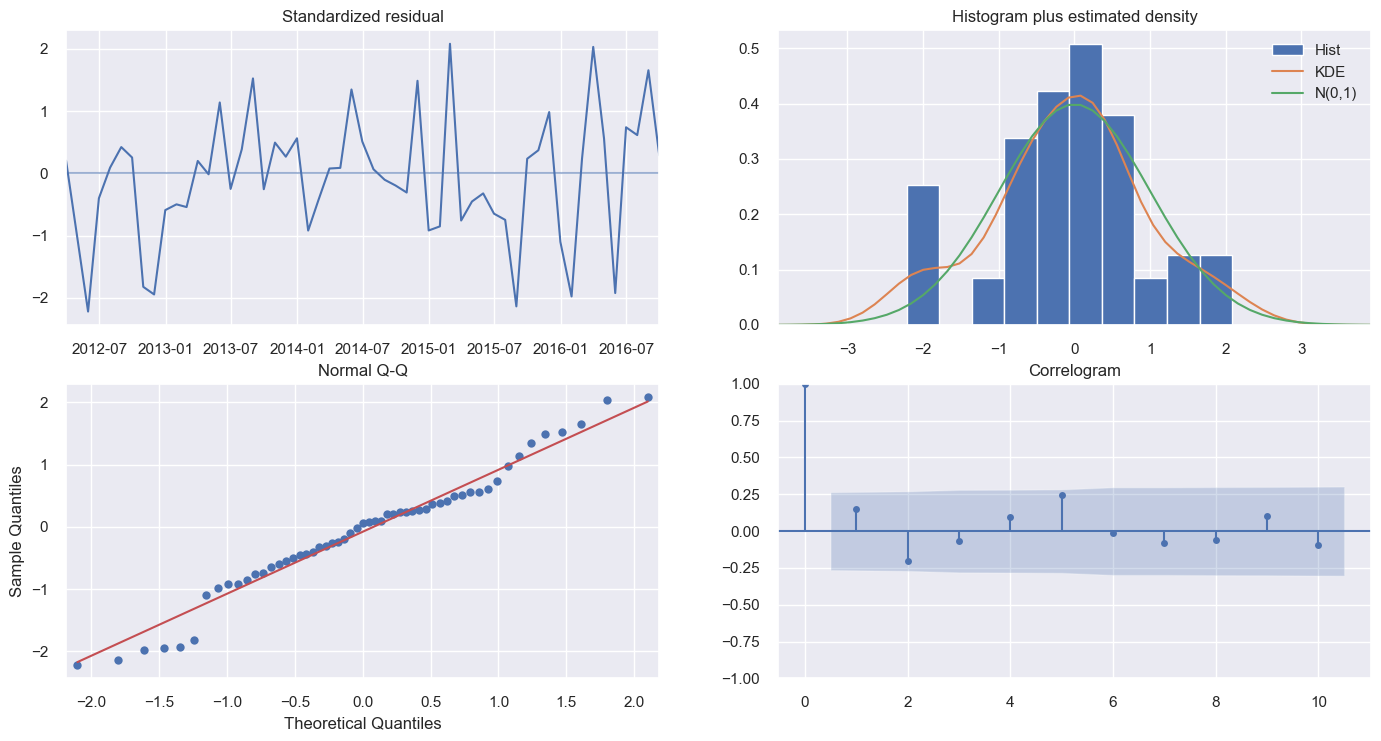

In [222]:
#Using Auto-Arima for p, d, q(Different Method)
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


### Hyper Parameter Tuning for Model Order

In [223]:
list_param = []
list_param_seasonal=[]
list_results_aic=[]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            list_param.append(param)
            list_param_seasonal.append(param_seasonal)
            list_results_aic.append(results.aic)
        except:
            continue
    break

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.50480D+00    |proj g|=  4.30640D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   1.053D-06   4.505D+00
  F =   4.5047749499292653     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:515.5443442919362
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20191D+00    |proj g|=  1.07821D-01


 This problem is unconstrained.



At iterate    5    f=  1.15572D+00    |proj g|=  8.98084D-03

At iterate   10    f=  1.15240D+00    |proj g|=  1.26744D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     14      1     0     0   9.778D-06   1.152D+00
  F =   1.1524013316539536     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:137.3737518085507
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20726D+00    |proj g|=  5.24864D-02

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:247.10932841009935
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34709D+00    |proj g|=  1.09307D-01

At iterate    5    f=  1.25912D+00    |proj g|=  1.80483D-02

At iterate   10    f=  1.25723D+00    |proj g|=  1.21441D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     14      1     0     0   1.214D-06   1.257D+00
  F =   1.2572313535956419     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)

 This problem is unconstrained.



At iterate    5    f=  4.99048D-01    |proj g|=  8.39369D-02

At iterate   10    f=  4.89777D-01    |proj g|=  9.33948D-03

At iterate   15    f=  4.46171D-01    |proj g|=  1.65358D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     33      1     0     0   2.429D-06   4.461D-01
  F =  0.44614074244220098     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:56.86004463841091
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.75163D+00    |proj g|=  4.19554D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     31      1     0     0   5.846D-07   1.752D+00
  F =   1.7516294520210407     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:207.68575753039863
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94091D+00    |proj g|=  2.96039D-06

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5     84      2     2     0   1.814D+05   9.341D+00
  F =   9.3409223405677420     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1070.8651468247226
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20191D+00    |proj g|=  1.07821D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  1.15599D+00    |proj g|=  9.17857D-03

At iterate   10    f=  1.15145D+00    |proj g|=  1.62901D-03

At iterate   15    f=  1.15137D+00    |proj g|=  2.32435D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     19      1     0     0   3.813D-06   1.151D+00
  F =   1.1513696339464115     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:139.2561382698909
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.


ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:161.90957587948085
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34709D+00    |proj g|=  1.09309D-01


 This problem is unconstrained.



At iterate    5    f=  1.27369D+00    |proj g|=  4.22706D-02

At iterate   10    f=  1.24665D+00    |proj g|=  1.36668D-02

At iterate   15    f=  1.24603D+00    |proj g|=  1.07470D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     19      1     0     0   1.075D-07   1.246D+00
  F =   1.2460308989031152     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:148.04752247495514
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  4.80498D-01    |proj g|=  2.31052D-02

At iterate   10    f=  4.44647D-01    |proj g|=  4.12823D-02

At iterate   15    f=  3.82100D-01    |proj g|=  8.02985D-03

At iterate   20    f=  3.81081D-01    |proj g|=  1.08878D-03

At iterate   25    f=  3.80991D-01    |proj g|=  3.45261D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     44      1     0     0   4.360D-06   3.810D-01
  F =  0.38099088164720840     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:51.43296050778176
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:199.11035693546162
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.60646D+00    |proj g|=  1.40768D+01

At iterate    5    f=  1.74527D+00    |proj g|=  1.08839D+00

At iterate   10    f=  1.66636D+00    |proj g|=  1.14500D-01

At iterate   15    f=  1.63368D+00    |proj g|=  1.34022D-01

At iterate   20    f=  1.60666D+00    |proj g|=  3.53127D-02

At iterate   25    f=  1.60127D+00    |proj g|=  1.72199D-02

At iterate   30    f=  1.60116D+00    |proj g|=  1.38500D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value


 This problem is unconstrained.


ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:192.5327199367209
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12408D+00    |proj g|=  4.48714D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   4.487D-06   1.124D+00
  F =   1.1240774789618921     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:134.1448326016557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00669D+00    |proj g|=  3.67585D+00


 This problem is unconstrained.



At iterate    5    f=  1.06707D+00    |proj g|=  6.01994D-02

At iterate   10    f=  1.06439D+00    |proj g|=  1.01594D-03

At iterate   15    f=  1.06439D+00    |proj g|=  1.32407D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     20      1     0     0   4.871D-06   1.064D+00
  F =   1.0643914191982526     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:129.3406217886008
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  1.02239D+00    |proj g|=  3.80378D-02

At iterate   10    f=  9.44618D-01    |proj g|=  7.26315D-02

At iterate   15    f=  9.41277D-01    |proj g|=  4.51890D-03

At iterate   20    f=  9.41075D-01    |proj g|=  8.26804D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   7.018D-07   9.411D-01
  F =  0.94107527730368312     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:117.28258161261988
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     10      1     0     0   1.258D-05   3.838D-01
  F =  0.38384895815273773     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(2, 2, 0, 12)12 - AIC:49.7587812294121
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.74585D-01    |proj g|=  1.71240D-01


 This problem is unconstrained.



At iterate    5    f=  5.20598D-01    |proj g|=  1.40550D-02

At iterate   10    f=  4.09015D-01    |proj g|=  1.20042D-01

At iterate   15    f=  3.83849D-01    |proj g|=  5.85991D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     28      1     0     0   3.743D-06   3.838D-01
  F =  0.38384887730027878     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(2, 2, 1, 12)12 - AIC:51.75877201223178
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  4.61955D-01    |proj g|=  1.24662D-02

At iterate   10    f=  3.97210D-01    |proj g|=  2.40430D-01

At iterate   15    f=  3.44633D-01    |proj g|=  7.69123D-03

At iterate   20    f=  3.44584D-01    |proj g|=  9.74637D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     34      1     0     0   9.746D-07   3.446D-01
  F =  0.34458448625157301     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:49.282631432679324


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:515.5443442919362

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:375.435196203917

ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:270.0847141015779

ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:292.92875796932054  

ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1355.5665835116574

ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:137.3737518085507

ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:56.86004463841091

ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:300.3019664915737

ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:276.7738991064223

ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:207.68575753039863

ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:225.26329946514497 

ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1070.8651468247226

ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:139.2561382698909

ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:148.04752247495514 

ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:51.43296050778176

ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:213.66919498529643

ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:199.11035693546162

ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:192.5327199367209

ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:134.1448326016557 

ARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:117.28258161261988

ARIMA(0, 0, 0)x(2, 2, 0, 12)12 - AIC:49.7587812294121

ARIMA(0, 0, 0)x(2, 2, 1, 12)12 - AIC:51.75877201223178

By Observing the Lowest AIC , we come to Seasonality Order of (2,2,0)12 and non-seasonal component is (1,1,1) as derived earlier by correlograms.

Seasonal Arima is used as we have seasonality component present. During Fall time period (July-Nov) the stock seems to rally on the news of product launch and product releases in that cycle of the year.

In [256]:
model = sm.tsa.SARIMAX(train,order=(1,1,1),seasonal_order=(2,2,0,12))
results=model.fit()
forecasts_train = results.predict(start='2012-01-31',end='2016-09-30')
forecasts_test = results.predict(start='2016-10-31',end='2019-12-31')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54179D+00    |proj g|=  8.84857D-02

At iterate    5    f=  1.40246D+00    |proj g|=  1.54636D-02

At iterate   10    f=  1.39967D+00    |proj g|=  1.70766D-02

At iterate   15    f=  1.39293D+00    |proj g|=  1.03834D-02

At iterate   20    f=  1.39275D+00    |proj g|=  2.25290D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   1.738D-06   1.393D+00
  F =   1.3927533090963329     

CONVERG

In [257]:
##Function to Calculate Result Metrics
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
def result_metrics(test_series,forecast_series,model_name):
  print('Result Metrics for {}'.format(model_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))
  print('Mean Absolute Percentage Error ',round(mean_absolute_percentage_error(test_series,forecast_series),3))
  print('Root Mean Squared Error : ',sqrt(mean_squared_error(test_series,forecast_series)))
    

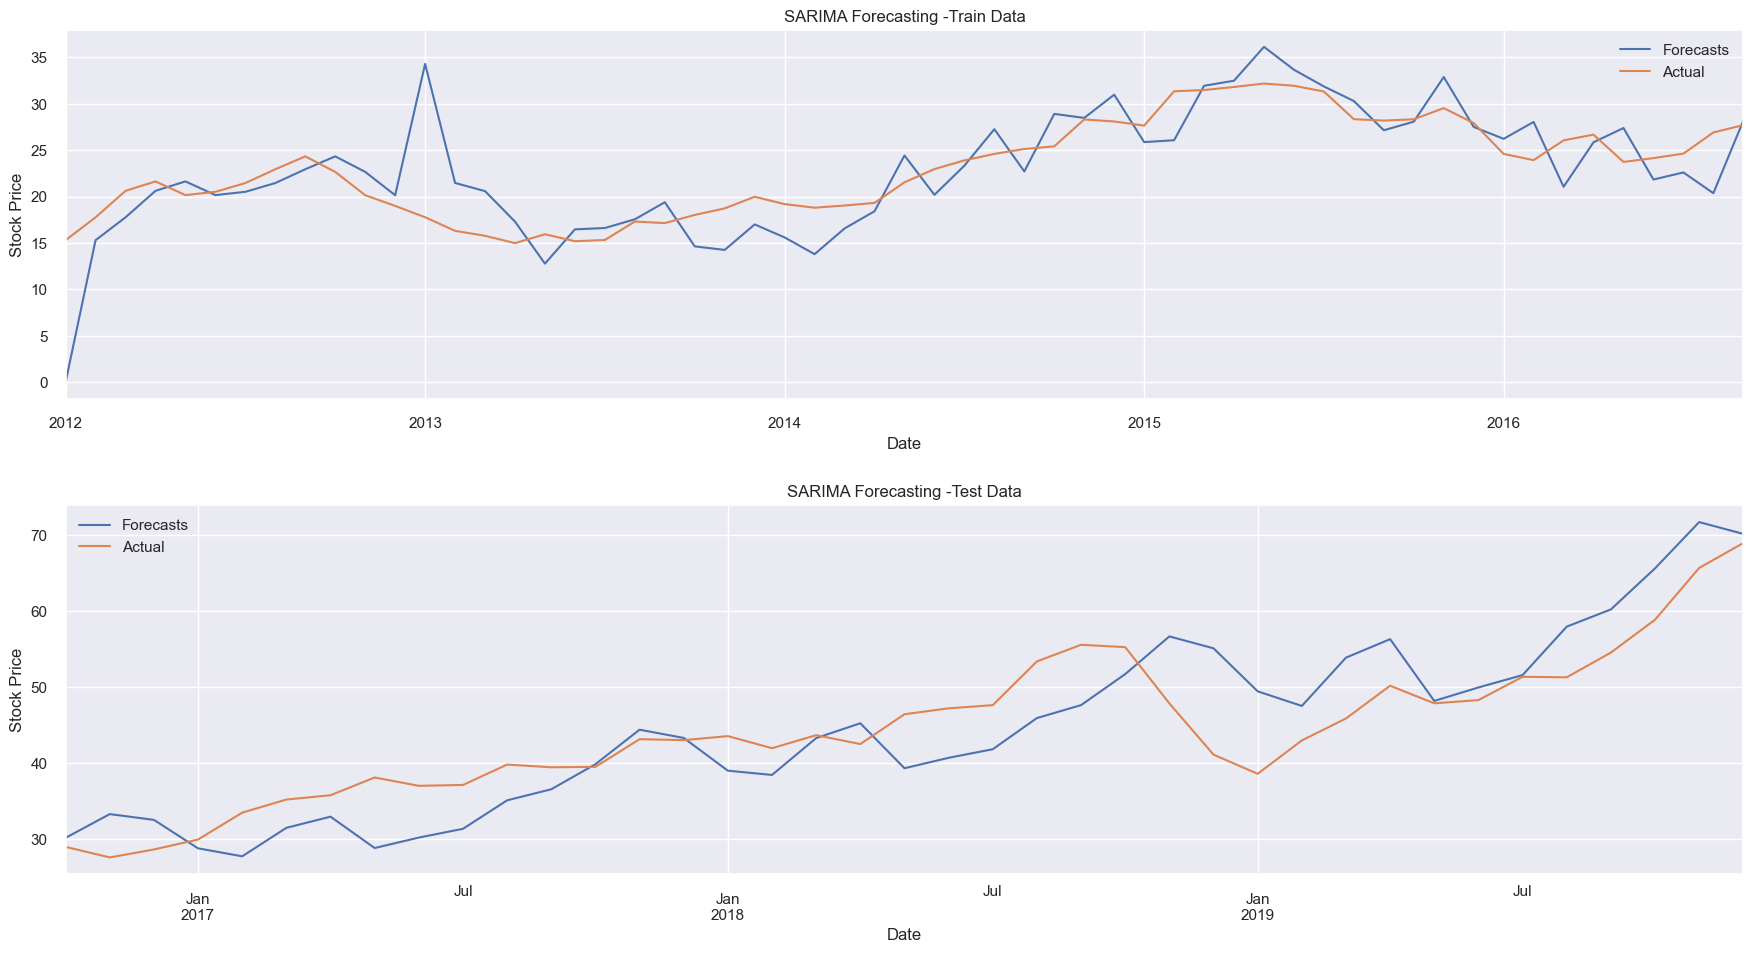

In [258]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
train.plot(label='Actual',ax=ax1)
ax1.set_ylabel('Stock Price')

forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
test.plot(label='Actual',ax=ax2)
ax2.set_ylabel('Stock Price')

ax1.legend()
ax2.legend()
plt.tight_layout(pad=2)

In [259]:
print(result_metrics(train,forecasts_train,'SARIMA-Train Data'))
print('----')
print(result_metrics(test,forecasts_test,'SARIMA-Test Data'))

Result Metrics for SARIMA-Train Data
R2 Score :  0.356
Mean Squared Error :  16.274
Mean Absolute Error :  2.779
Mean Absolute Percentage Error  0.136
Root Mean Squared Error :  4.034120937886546
None
----
Result Metrics for SARIMA-Test Data
R2 Score :  0.626
Mean Squared Error :  32.782
Mean Absolute Error :  4.769
Mean Absolute Percentage Error  0.111
Root Mean Squared Error :  5.725586852381987
None


In [232]:
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                   57
Model:             SARIMAX(1, 1, 1)x(2, 2, [], 12)   Log Likelihood                 -79.387
Date:                             Wed, 30 Nov 2022   AIC                            168.774
Time:                                     11:17:54   BIC                            176.103
Sample:                                 01-31-2012   HQIC                           171.203
                                      - 09-30-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7741      0.436      1.775      0.076      -0.080       1.629
ma.L1         -0.5035      

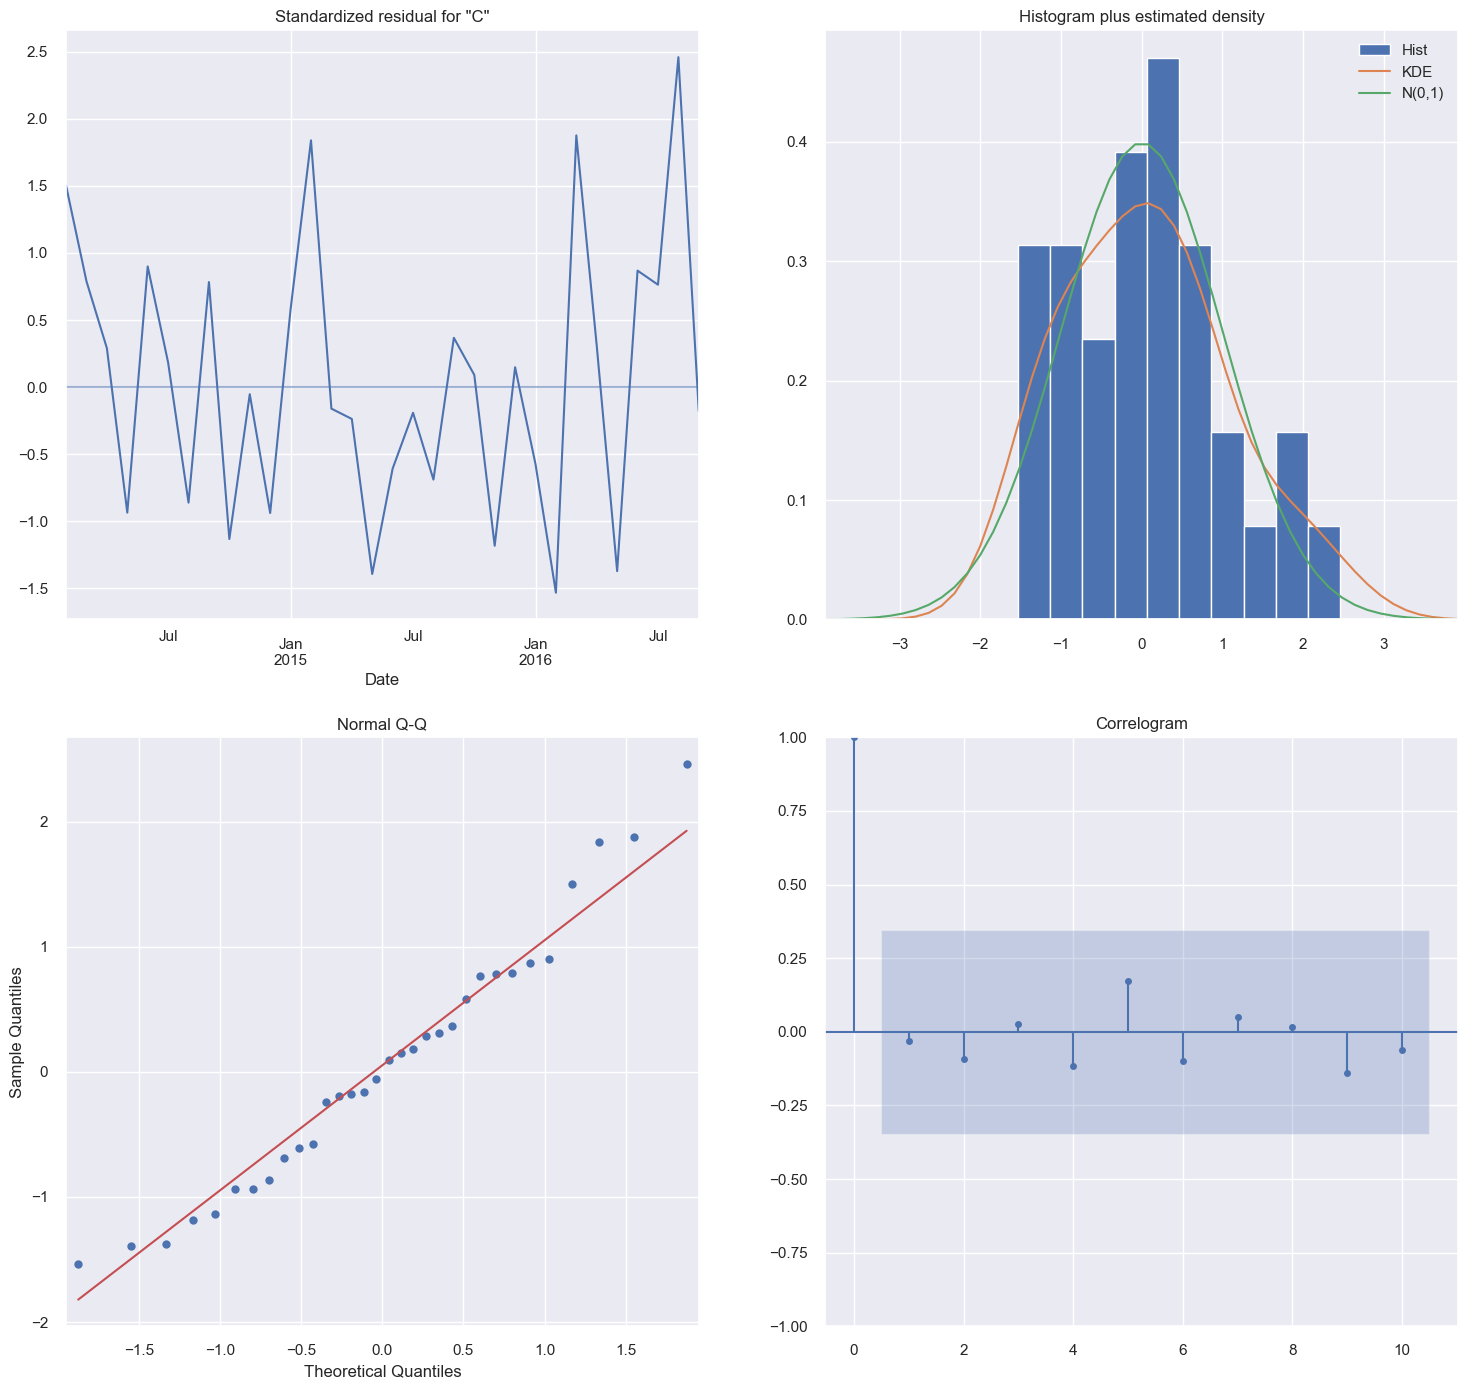

In [231]:
##Checking Model Diagnotics on Training Data
results.plot_diagnostics(figsize=(16, 16))
plt.show()

Inference from Residual Analysis :-

->We observe that the residual plot kind of follows stationarity.

->The Distribution of Training Data residuals is showing almost Normal Distribution.

->The QQPlot points towards Normal Distribution

->Correlogram shows no relation -which indicates they are un-correlated.

Overall the model is captured the Stock Price in a good manner.

### Residual Analysis

In [233]:
residuals_test = test-forecasts_test

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


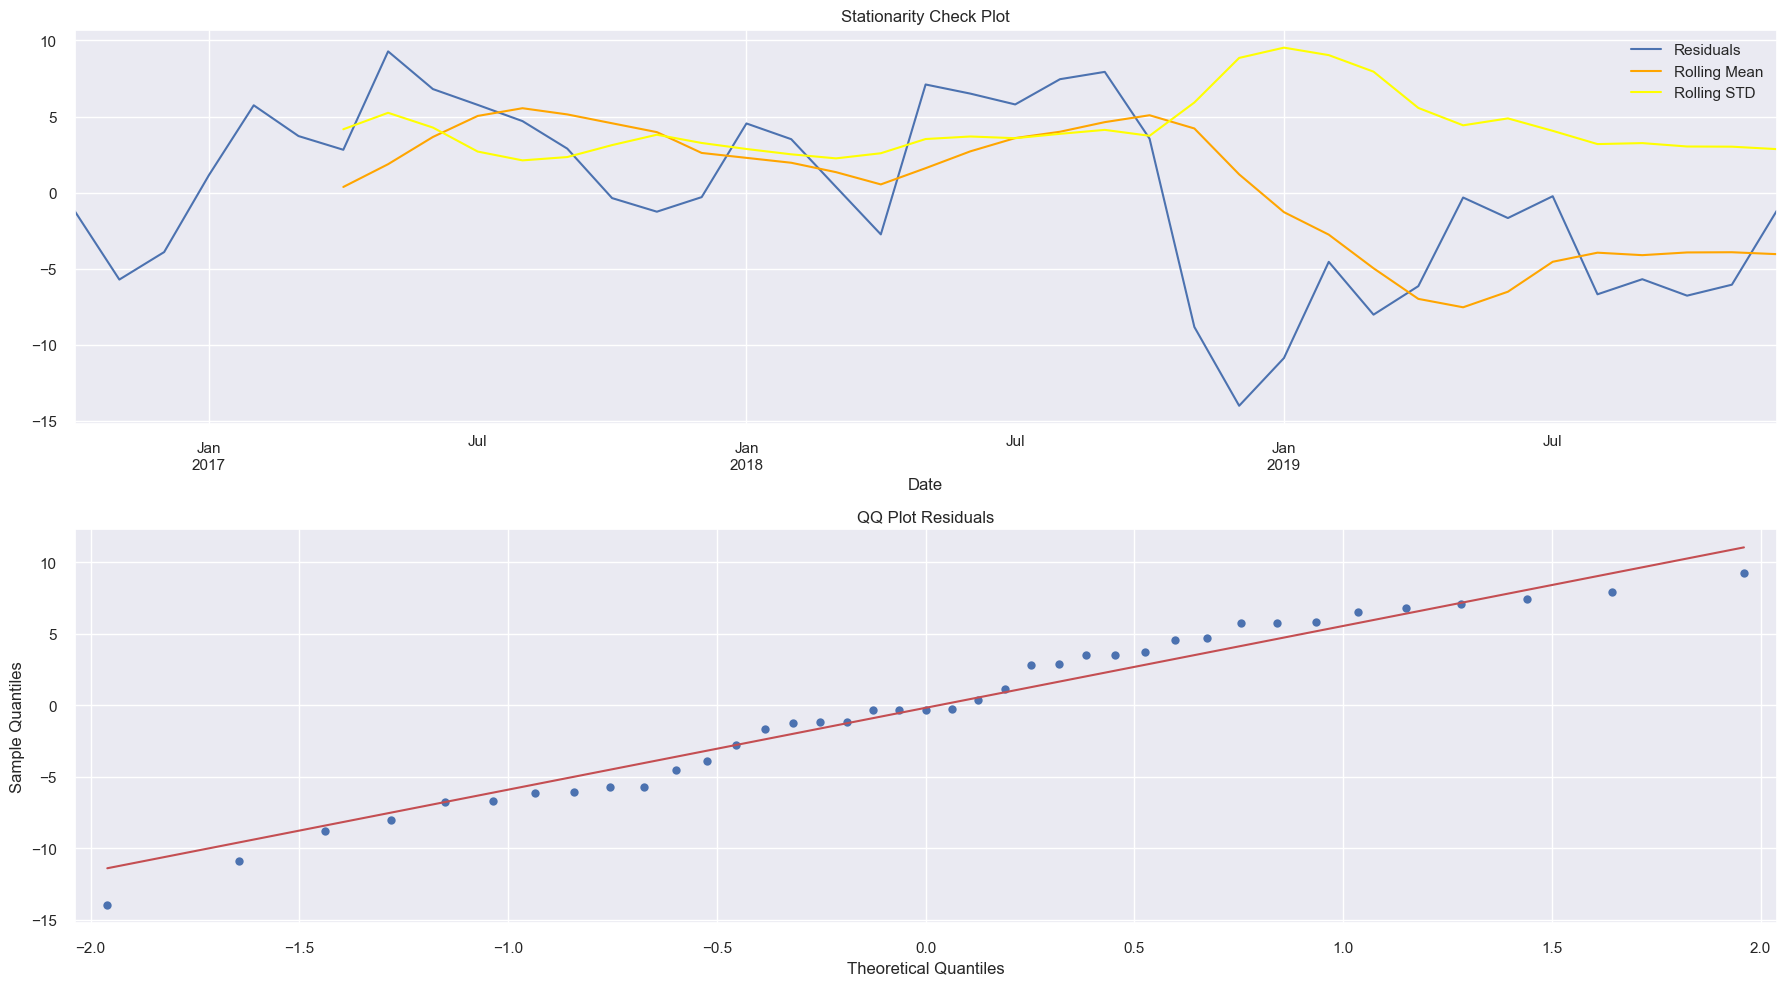

In [234]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))


residuals_test.plot(label='Residuals',ax=ax1,title='Stationarity Check Plot')
residuals_test.rolling(7).mean().plot(label='Rolling Mean',c='orange',ax=ax1)
residuals_test.rolling(7).std().plot(label='Rolling STD',c='yellow',ax=ax1)

qq_plot = qq(residuals_test,line='s',ax=ax2)
ax2.set_title('QQ Plot Residuals')
ax1.legend()
ax2.legend()
plt.tight_layout(pad=1)

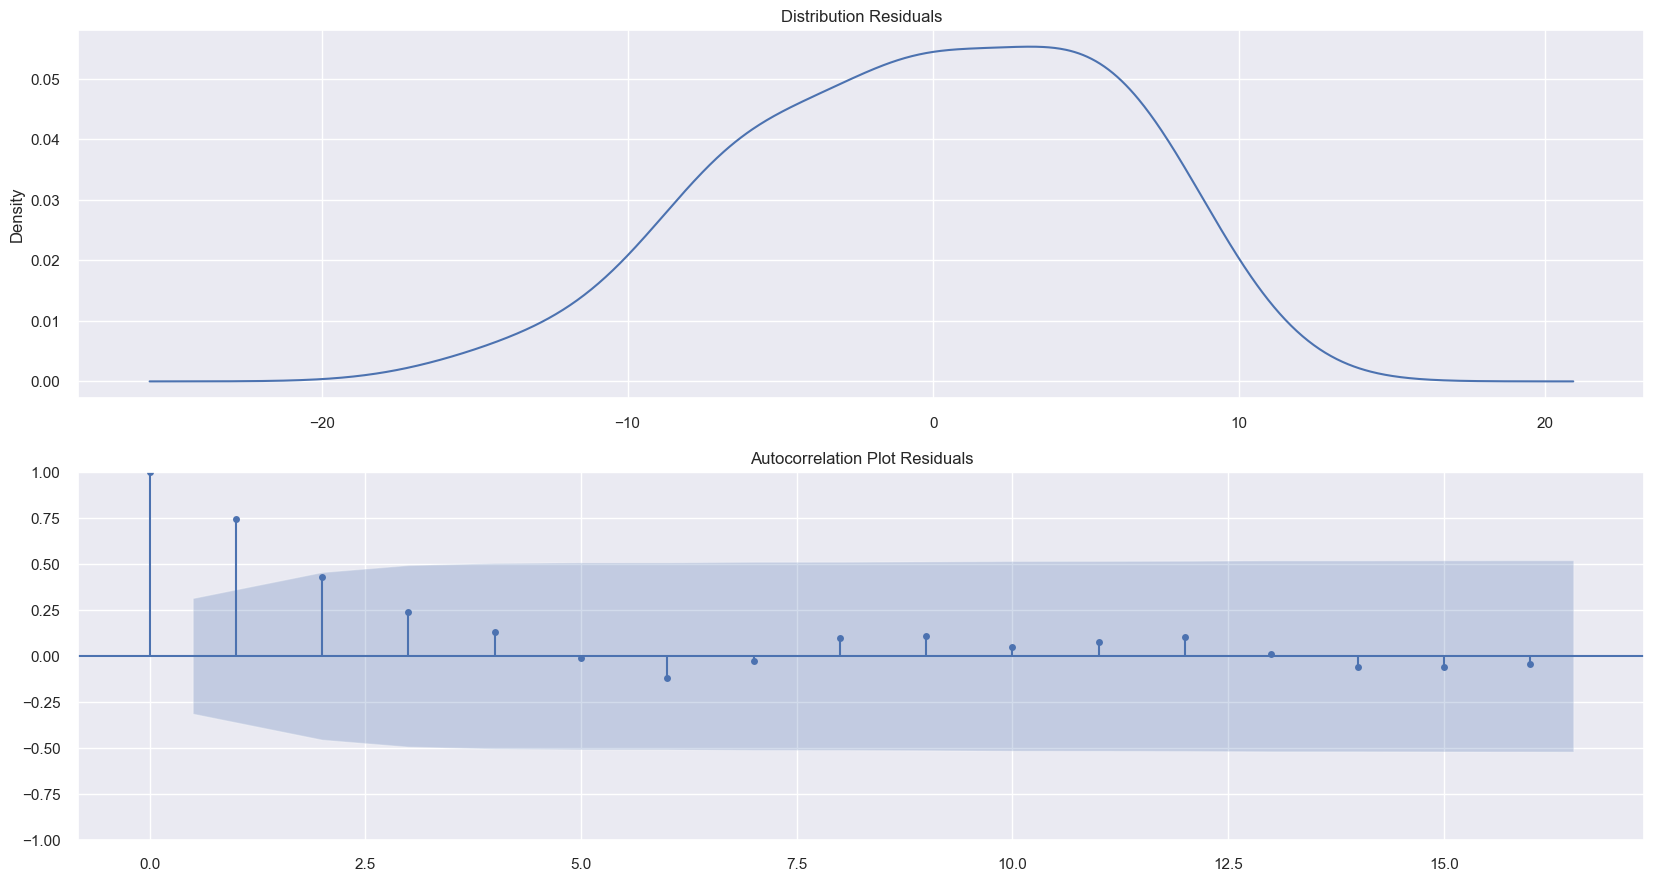

In [235]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

residuals_test.plot(kind='kde',ax=ax1,title='Distribution Residuals')

acf = plot_acf(residuals_test,ax=ax2,title='Autocorrelation Plot Residuals')

In [236]:
residuals_test.describe()

count    39.000000
mean     -0.168518
std       5.797921
min     -13.988359
25%      -5.108477
50%      -0.288128
75%       4.627034
max       9.283400
dtype: float64

In [237]:
train_list = {}
test_list = {}
time_series_splits = TimeSeriesSplit(n_splits=4)
X = modelling_series.values

index = 1
for train_index, test_index in time_series_splits.split(X):
    train = X[train_index]
    test = X[test_index]
    train_list[index] = train
    test_list[index] = test
    index += 1

In [238]:
modelling_series

Date
2012-01-31    15.306357
2012-02-29    17.770393
2012-03-31    20.625276
2012-04-30    21.642964
2012-05-31    20.166899
                ...    
2019-08-31    51.239432
2019-09-30    54.498750
2019-10-31    58.821630
2019-11-30    65.630126
2019-12-31    68.917374
Freq: M, Name: Close, Length: 96, dtype: float64

In [241]:
def backtest_model(train,test):
    model = sm.tsa.SARIMAX(train,order=(1,1,1),seasonal_order=(2,2,0,12))
    results=model.fit()


    # train_get_dates_beginning = '2012-01-31'
    # train_get_dates_ending = str(modelling_series.index[len(train)].date())
    # test_get_dates_beginning = train_get_dates_ending
    # test_get_dates_ending = str(modelling_series.index[len(train)+len(test)].date())


    # forecasts_train = results.predict(start=train_get_dates_beginning,end=train_get_dates_ending)
    # forecasts_test = results.predict(start=test_get_dates_beginning,end=test_get_dates_ending)

    forecasts_train = results.predict(start=0,end=len(train))
    forecasts_test = results.predict(start=len(train),end=len(train)+len(test))


    fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

    train = pd.DataFrame(train)
    test = pd.DataFrame(test)

    forecasts_train = pd.DataFrame(forecasts_train)
    forecasts_test = pd.DataFrame(forecasts_test)

    forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
    train.plot(label='Actual',ax=ax1)
    ax1.set_ylabel('Stock Price')

    forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
    test.plot(label='Actual',ax=ax2)
    ax2.set_ylabel('Stock Price')

    ax1.legend()
    ax2.legend()
    plt.tight_layout(pad=2)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86662D+00    |proj g|=  3.11336D-01


 This problem is unconstrained.



At iterate    5    f=  1.68076D+00    |proj g|=  2.24582D-02

At iterate   10    f=  1.67174D+00    |proj g|=  7.32461D-03

At iterate   15    f=  1.66995D+00    |proj g|=  9.60347D-04

At iterate   20    f=  1.66991D+00    |proj g|=  2.43265D-04

At iterate   25    f=  1.66983D+00    |proj g|=  5.08612D-04

At iterate   30    f=  1.66982D+00    |proj g|=  2.16552D-04

At iterate   35    f=  1.66982D+00    |proj g|=  1.27244D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     49      1     0     0   3.246D-05   1.670D+00
  F =   1.6698181391103075     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

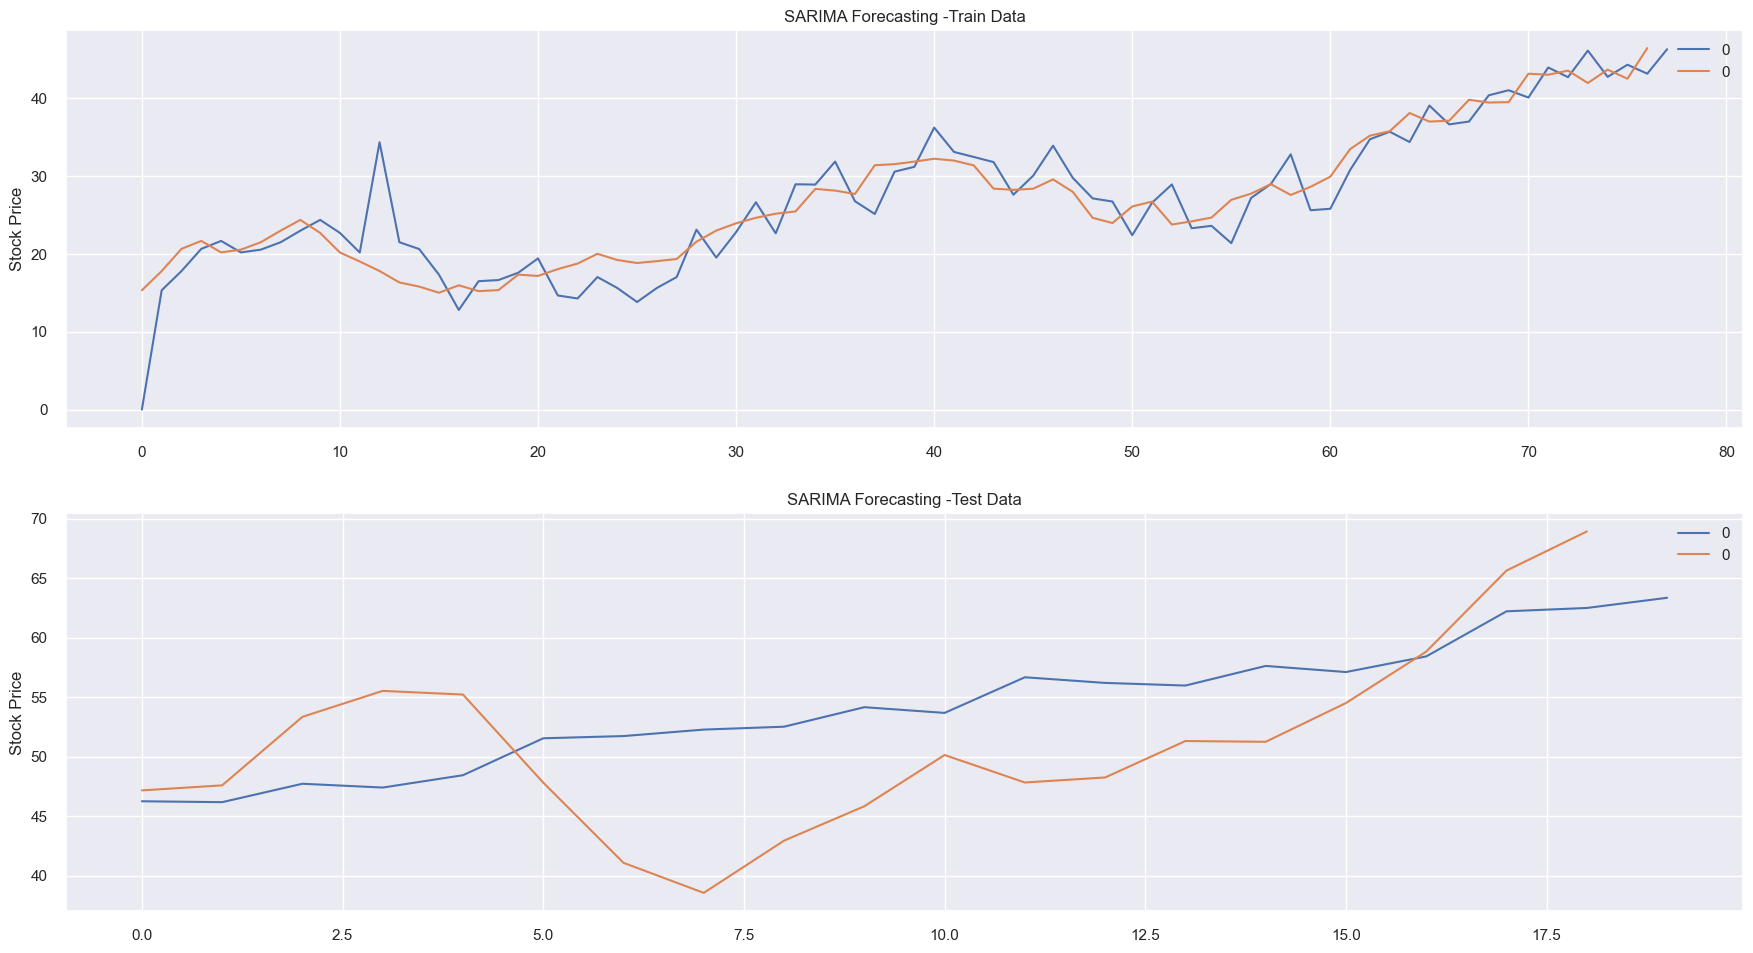

In [202]:
backtest_model(train,test)